In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nltk

import time
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
!pip install --upgrade gensim
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrewpetravicius/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewpetravicius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
#data preparation
raw_data=pd.read_csv('data.csv')
#data description:
#count: number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when 
#hate_speech: number of CF users who judged the tweet to be hate speech
#offensive_language: number of CF users who judged the tweet to be offensive
#neither: number of CF users who judged the tweet to be neither offensive nor non-offensive
#class: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
#tweet: the actual tweet



       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
...           ...    ...          ...                 ...      ...    ...   
24778       25291      3            0                   2        1      1   
24779       25292      3            0                   1        2      2   
24780       25294      3            0                   3        0      1   
24781       25295      6            0                   6        0      1   
24782       25296      3            0                   0        3      2   

                                                   tweet  
0      !!! RT @m

In [4]:
#Since only dealing with english tweets, only care about the stopwords that are in English
stopwords = nltk.corpus.stopwords.words('english')
#rt/retweet are twitter-specific stopwords we dont want to consider  
twitter_stopwords=('rt','retweet')
stopwords.extend(twitter_stopwords)

#create stemmer object (WHY STEMMER OVER LEMMINZATION?)
stemmer = PorterStemmer()

def preprocess(data):
    processed_data=list()
    for index, tweet in data.iterrows():
        #go to lower case, as capitalization likely does not differentiate between hate speech and offensive
        tweet = tweet.str.lower()
        #get rid of: links, punctuation, large whitespace 
        tweet = tweet.apply(lambda f: re.sub(r'[.,"\'-?:!;]', '', f))
        tweet = tweet.apply(lambda e: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", e))  
        #tokenization
        tweet= tweet.apply(lambda e: word_tokenize(e))
        # removal of stopwords
        tweet=tweet.apply(lambda x: [item for item in x if item not in stopwords])
        # stemming of the tweets
        tweet = tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
        #to sentence
        tweet=tweet.values
        tweet=tweet[0]
        #join to one sentence
        tweet=' '.join(tweet)
        processed_data.append(tweet)
    return processed_data

#drop unneeded columns
dropped_data=raw_data.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1)


In [5]:
#frequency finder
def freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    return d


In [6]:
print(freq(dropped_data['class']))
#we see that tweets with hate speech are a lot less frequent than ones with hate speech. This is a sign of unbalanced data. 
#To solve this, we will upsample


{2: 4163, 1: 19190, 0: 1430}


In [45]:
#Upsampling procedure
from sklearn.utils import resample
#upsampling
dropped_data_maj=dropped_data[dropped_data['class']==1]
dropped_data_min_hate=dropped_data[dropped_data['class']==0]
dropped_data_min_neither=dropped_data[dropped_data['class']==2]


dropped_data_min_hate_upsampled=resample(dropped_data_min_hate,replace=True,n_samples=len(dropped_data_maj),random_state=123)
dropped_data_min_neither_upsampled=resample(dropped_data_min_neither,replace=True,n_samples=len(dropped_data_maj),random_state=123)


#new upsampled dataset
df_upsampled=dropped_data_maj.append(dropped_data_min_hate_upsampled)
df_upsampled=df_upsampled.append(dropped_data_min_neither_upsampled)
#separate into X and y
X_upsampled=df_upsampled['tweet']
y_upsampled=df_upsampled['class'].astype(int)
X_not=dropped_data['tweet']
y_not=dropped_data['class'].astype(int)
#y=pd.get_dummies(df['class'])


In [46]:
def preprocessTF(text_string):
    whitespace = '\s+'
    regURL = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regAt = '@[\w\-]+'
    res = re.sub(whitespace, ' ', text_string)
    res = re.sub(regURL, '', res)
    return re.sub(regAt, '', res)

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
)

In [47]:
#Feature Engineering
#TF-IDF Features-F1
# TF-IDF feature matrix
tfidf_upsampled = tfidf_vectorizer.fit_transform(X_upsampled)
tfidf_not = tfidf_vectorizer.fit_transform(X_not)

#split data (tfidf based)
tfidf_upsampled_train, tfidf_upsampled_test, y_upsampled_train, y_upsampled_test = train_test_split(tfidf_upsampled,y_upsampled,
                                                                                                    test_size=0.3,
                                                                                                    random_state=123)
tfidf_not_train, tfidf_not_test, y_not_train, y_not_test = train_test_split(tfidf_not,y_not,test_size=0.3,random_state=123)

In [48]:
#Logistic Regression
print("LOGISTIC REGRESSION")
start_not=time.time()
model_not_LR = LogisticRegression().fit(tfidf_not_train,y_not_train)
end_not=time.time()
#get time
runtime_not_LR=end_not-start_not
#get predictions
yhat_not = model_not_LR.predict(tfidf_not_test)
#get accuracy
accuracy_not_LR=accuracy_score(yhat_not,y_not_test)
#get results
results=classification_report(yhat_not,y_not_test)
print("Not Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_not_LR,4))
print("Runtime: ",round(runtime_not_LR,4))
print()

start_upsampled=time.time()
model_upsampled_LR = LogisticRegression().fit(tfidf_upsampled_train,y_upsampled_train)
end_upsampled=time.time()
#get time
runtime_upsampled_LR=end_upsampled-start_upsampled
#get predictions
yhat_upsampled = model_upsampled_LR.predict(tfidf_upsampled_test)
#get accuracy
accuracy_upsampled_LR=accuracy_score(yhat_upsampled,y_upsampled_test)
#get results
results=classification_report(yhat_upsampled,y_upsampled_test)
print("Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_upsampled_LR,4))
print("Runtime: ",round(runtime_upsampled_LR,4))

LOGISTIC REGRESSION


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Not Upsampled
------------
              precision    recall  f1-score   support

           0       0.35      0.34      0.35       445
           1       0.92      0.92      0.92      5780
           2       0.80      0.83      0.81      1210

    accuracy                           0.87      7435
   macro avg       0.69      0.70      0.69      7435
weighted avg       0.87      0.87      0.87      7435

Accuracy: 0.8699
Runtime:  0.7636

Upsampled
------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6101
           1       0.90      0.99      0.94      5143
           2       0.99      0.96      0.97      6027

    accuracy                           0.96     17271
   macro avg       0.96      0.96      0.96     17271
weighted avg       0.97      0.96      0.96     17271

Accuracy: 0.9621
Runtime:  1.5777


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Upsampled')

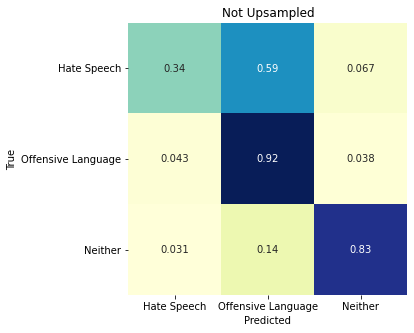

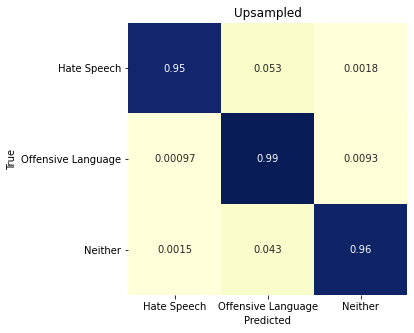

In [49]:
confMat_not = confusion_matrix(yhat_not,y_not_test)
confMat_upsampled = confusion_matrix(yhat_upsampled,y_upsampled_test)

#Since there are 3 classes, want a 3x3 confusion matrix
dims_not = np.zeros((3,3))
dims_upsampled=np.zeros((3,3))
for i in range(0,3):
    dims_not[i,:] = confMat_not[i,:]/confMat_not[i,:].sum()
    dims_upsampled[i,:] = confMat_upsampled[i,:]/confMat_upsampled[i,:].sum()
map_not = pd.DataFrame(dims_not, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
map_upsampled = pd.DataFrame(dims_upsampled, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
plt.figure(figsize=(5,5))
sb.heatmap(map_not,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Not Upsampled")

plt.figure(figsize=(5,5))
sb.heatmap(map_upsampled,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Upsampled")


In [50]:
#Random Forest
print("Random Forest")
start_not=time.time()
model_not_RF = RandomForestClassifier().fit(tfidf_not_train,y_not_train)
end_not=time.time()
#get time
runtime_not_RF=end_not-start_not
#get predictions
yhat_not = model_not_RF.predict(tfidf_not_test)
#get accuracy
accuracy_not_RF=accuracy_score(yhat_not,y_not_test)
#get results
results=classification_report(yhat_not,y_not_test)
print("Not Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_not_RF,4))
print("Runtime: ",round(runtime_not_RF,4))
print()

start_upsampled=time.time()
model_upsampled_RF = RandomForestClassifier().fit(tfidf_upsampled_train,y_upsampled_train)
end_upsampled=time.time()
#get time
runtime_upsampled_RF=end_upsampled-start_upsampled
#get predictions
yhat_upsampled = model_upsampled_RF.predict(tfidf_upsampled_test)
#get accuracy
accuracy_upsampled_RF=accuracy_score(yhat_upsampled,y_upsampled_test)
#get results
results=classification_report(yhat_upsampled,y_upsampled_test)
print("Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_upsampled_RF,4))
print("Runtime: ",round(runtime_upsampled_RF,4))

Random Forest
Not Upsampled
------------
              precision    recall  f1-score   support

           0       0.22      0.48      0.30       198
           1       0.95      0.93      0.94      5882
           2       0.89      0.82      0.85      1355

    accuracy                           0.90      7435
   macro avg       0.69      0.75      0.70      7435
weighted avg       0.92      0.90      0.91      7435

Accuracy: 0.8989
Runtime:  10.5743

Upsampled
------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6005
           1       0.92      1.00      0.96      5247
           2       0.99      0.96      0.98      6019

    accuracy                           0.97     17271
   macro avg       0.97      0.97      0.97     17271
weighted avg       0.97      0.97      0.97     17271

Accuracy: 0.9727
Runtime:  28.7249


Text(0.5, 1.0, 'Upsampled')

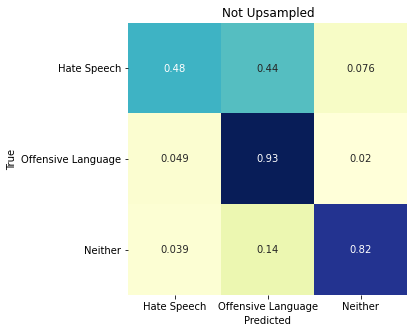

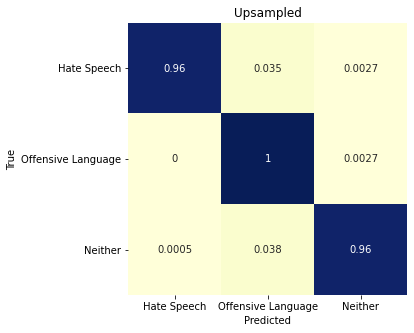

In [51]:
confMat_not = confusion_matrix(yhat_not,y_not_test)
confMat_upsampled = confusion_matrix(yhat_upsampled,y_upsampled_test)

#Since there are 3 classes, want a 3x3 confusion matrix
dims_not = np.zeros((3,3))
dims_upsampled=np.zeros((3,3))
for i in range(0,3):
    dims_not[i,:] = confMat_not[i,:]/confMat_not[i,:].sum()
    dims_upsampled[i,:] = confMat_upsampled[i,:]/confMat_upsampled[i,:].sum()
map_not = pd.DataFrame(dims_not, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
map_upsampled = pd.DataFrame(dims_upsampled, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
plt.figure(figsize=(5,5))
sb.heatmap(map_not,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Not Upsampled")

plt.figure(figsize=(5,5))
sb.heatmap(map_upsampled,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Upsampled")


In [52]:
#Support Vector Machine
#Support Vector Machine
print("SUPPORT VECTOR MACHINE")
start_not=time.time()
model_not_SVM = LinearSVC().fit(tfidf_not_train,y_not_train)
end_not=time.time()
#get time
runtime_not_SVM=end_not-start_not
#get predictions
yhat_not = model_not_SVM.predict(tfidf_not_test)
#get accuracy
accuracy_not_SVM=accuracy_score(yhat_not,y_not_test)
#get results
results=classification_report(yhat_not,y_not_test)
print("Not Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_not_SVM,4))
print("Runtime: ",round(runtime_not_SVM,4))
print()

start_upsampled=time.time()
model_upsampled_SVM = LinearSVC().fit(tfidf_upsampled_train,y_upsampled_train)
end_upsampled=time.time()
#get time
runtime_upsampled_SVM=end_upsampled-start_upsampled
#get predictions
yhat_upsampled = model_upsampled_SVM.predict(tfidf_upsampled_test)
#get accuracy
accuracy_upsampled_SVM=accuracy_score(yhat_upsampled,y_upsampled_test)
#get results
results=classification_report(yhat_upsampled,y_upsampled_test)
print("Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_upsampled_SVM,4))
print("Runtime: ",round(runtime_upsampled_SVM,4))

SUPPORT VECTOR MACHINE


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Not Upsampled
------------
              precision    recall  f1-score   support

           0       0.36      0.26      0.30       589
           1       0.89      0.91      0.90      5649
           2       0.72      0.76      0.74      1197

    accuracy                           0.83      7435
   macro avg       0.66      0.64      0.65      7435
weighted avg       0.82      0.83      0.82      7435

Accuracy: 0.8301
Runtime:  1.0566

Upsampled
------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6104
           1       0.89      0.99      0.94      5120
           2       0.99      0.95      0.97      6047

    accuracy                           0.96     17271
   macro avg       0.96      0.96      0.96     17271
weighted avg       0.96      0.96      0.96     17271

Accuracy: 0.9585
Runtime:  5.4036


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Text(0.5, 1.0, 'Upsampled')

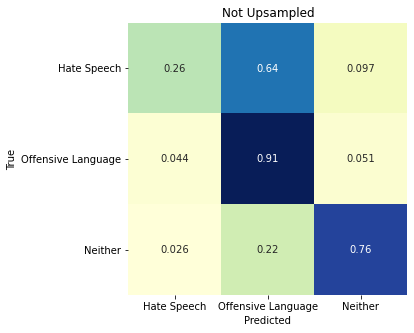

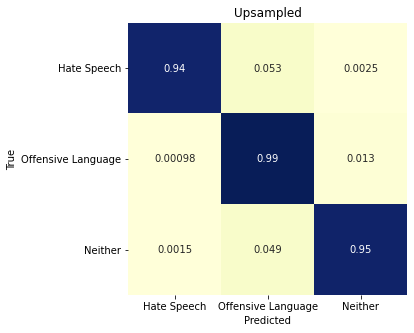

In [53]:
confMat_not = confusion_matrix(yhat_not,y_not_test)
confMat_upsampled = confusion_matrix(yhat_upsampled,y_upsampled_test)

#Since there are 3 classes, want a 3x3 confusion matrix
dims_not = np.zeros((3,3))
dims_upsampled=np.zeros((3,3))
for i in range(0,3):
    dims_not[i,:] = confMat_not[i,:]/confMat_not[i,:].sum()
    dims_upsampled[i,:] = confMat_upsampled[i,:]/confMat_upsampled[i,:].sum()
map_not = pd.DataFrame(dims_not, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
map_upsampled = pd.DataFrame(dims_upsampled, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
plt.figure(figsize=(5,5))
sb.heatmap(map_not,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Not Upsampled")

plt.figure(figsize=(5,5))
sb.heatmap(map_upsampled,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Upsampled")


In [54]:
#Naive Bayes (independence of features? maybe...check on it; multi-class? yes)
print("NAIVE BAYES")
start_not=time.time()
model_not_NB = GaussianNB().fit(tfidf_not_train.toarray(),y_not_train)
end_not=time.time()
#get time
runtime_not_NB=end_not-start_not
#get predictions
yhat_not = model_not_NB.predict(tfidf_not_test.toarray())
#get accuracy
accuracy_not_NB=accuracy_score(yhat_not,y_not_test)
#get results
results=classification_report(yhat_not,y_not_test)
print("Not Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_not_LR,4))
print("Runtime: ",round(runtime_not_LR,4))
print()

start_upsampled=time.time()
model_upsampled_NB = GaussianNB().fit(tfidf_upsampled_train.toarray(),y_upsampled_train)
end_upsampled=time.time()
#get time
runtime_upsampled_NB=end_upsampled-start_upsampled
#get predictions
yhat_upsampled = model_upsampled_NB.predict(tfidf_upsampled_test.toarray())
#get accuracy
accuracy_upsampled_NB=accuracy_score(yhat_upsampled,y_upsampled_test)
#get results
results=classification_report(yhat_upsampled,y_upsampled_test)
print("Upsampled")
print("------------")
print(results)
print("Accuracy:" , round(accuracy_upsampled_NB,4))
print("Runtime: ",round(runtime_upsampled_NB,4))

NAIVE BAYES
Not Upsampled
------------
              precision    recall  f1-score   support

           0       0.36      0.13      0.19      1187
           1       0.76      0.88      0.82      4972
           2       0.58      0.57      0.58      1276

    accuracy                           0.71      7435
   macro avg       0.57      0.53      0.53      7435
weighted avg       0.67      0.71      0.68      7435

Accuracy: 0.8699
Runtime:  0.7636

Upsampled
------------
              precision    recall  f1-score   support

           0       0.53      0.96      0.69      3229
           1       0.67      0.66      0.67      5807
           2       0.99      0.70      0.82      8235

    accuracy                           0.73     17271
   macro avg       0.73      0.77      0.72     17271
weighted avg       0.80      0.73      0.74     17271

Accuracy: 0.7338
Runtime:  24.8651


Text(0.5, 1.0, 'Upsampled')

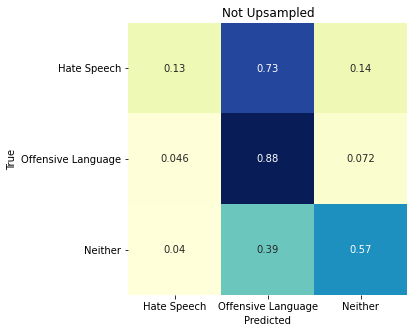

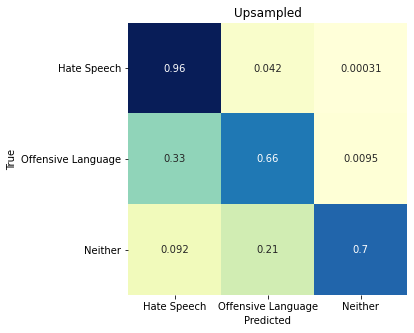

In [55]:
confMat_not = confusion_matrix(yhat_not,y_not_test)
confMat_upsampled = confusion_matrix(yhat_upsampled,y_upsampled_test)

#Since there are 3 classes, want a 3x3 confusion matrix
dims_not = np.zeros((3,3))
dims_upsampled=np.zeros((3,3))
for i in range(0,3):
    dims_not[i,:] = confMat_not[i,:]/confMat_not[i,:].sum()
    dims_upsampled[i,:] = confMat_upsampled[i,:]/confMat_upsampled[i,:].sum()
map_not = pd.DataFrame(dims_not, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
map_upsampled = pd.DataFrame(dims_upsampled, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])
plt.figure(figsize=(5,5))
sb.heatmap(map_not,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Not Upsampled")

plt.figure(figsize=(5,5))
sb.heatmap(map_upsampled,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Upsampled")


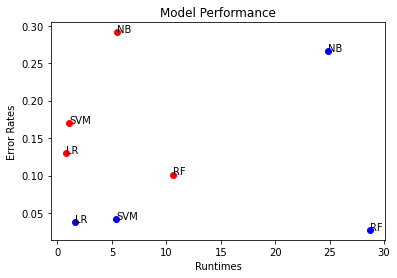

In [56]:
#Plot results (error rate/runtime)
error_rates_not=[1-accuracy_not_LR,1-accuracy_not_RF,1-accuracy_not_SVM,1-accuracy_not_NB]
runtimes_not=[runtime_not_LR,runtime_not_RF,runtime_not_SVM,runtime_not_NB]
error_rates_upsampled=[1-accuracy_upsampled_LR,1-accuracy_upsampled_RF,1-accuracy_upsampled_SVM,1-accuracy_upsampled_NB]
runtimes_upsampled=[runtime_upsampled_LR,runtime_upsampled_RF,runtime_upsampled_SVM,runtime_upsampled_NB]


names=['LR','RF', 'SVM', 'NB']
plt.scatter(runtimes_not,error_rates_not,c='r')
plt.scatter(runtimes_upsampled,error_rates_upsampled,c='b')
plt.xlabel('Runtimes')
plt.ylabel('Error Rates')
plt.title('Model Performance')

for i,model in enumerate(names):
    plt.annotate(model, (runtimes_not[i],error_rates_not[i]))
    plt.annotate(model, (runtimes_upsampled[i],error_rates_upsampled[i]))



In [57]:
#Sentiment Analysis w Polarity Scores as Features
sentimentAnalyzer=SIA()
    
def getSentiment(tweet):
    #get the sentiment through library's polarity score feature
    sentiment=sentimentAnalyzer.polarity_scores(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]#,tags[0], tags[1],tags[2]]
    return features

def sentiment_analysis_array(df):
    features=[]
    i=0
    for tweet in df:
        i+=1
        features.append(getSentiment(tweet))
    return np.array(features)

dataFeatures = sentiment_analysis_array(X_upsampled)
#final_features

dataFeats = pd.DataFrame({'Neg':dataFeatures[:,0],'Pos':dataFeatures[:,1],'Neu':dataFeatures[:,2],'Compound':dataFeatures[:,3]})
dataFeats

,Neg,Pos,Neu,Compound
0,0.237,0.000,0.763,-0.6876
1,0.538,0.000,0.462,-0.9550
2,0.000,0.344,0.656,0.5673
3,0.249,0.081,0.669,-0.7762
4,0.101,0.155,0.744,0.3046
...,...,...,...,...
57565,0.067,0.244,0.688,0.6568
57566,0.000,0.000,1.000,0.0000
57567,0.162,0.000,0.838,-0.4019
57568,0.000,0.451,0.549,0.6249


In [58]:
# F2-Conctaenation of tf-idf scores and sentiment scores
#Create new data
tfidf2 = tfidf_upsampled.toarray()

X2 = np.concatenate([dataFeats,tfidf2],axis=1)
X2 = pd.DataFrame(X2)

  
X2_train, X2_test, y_train, y_test = train_test_split(X2, y_upsampled, random_state=123, test_size=0.3)
]

In [59]:
#Logistic Regression]
start=time.time()
modelLR = LogisticRegression().fit(X2_train,y_train)
end=time.time()
#get time
runtimeLR=end-start
#get predictions
yhat = modelLR.predict(X2_test)
#get accuracy
accuracyLR=accuracy_score(yhat,y_test)
#get results
results=classification_report(yhat,y_test)
print("LOGISTIC REGRESSION")
print(results)
print("Accuracy:" , round(accuracyLR,4))
print("Runtime: ",round(runtimeLR,4))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6098
           1       0.90      0.99      0.94      5144
           2       0.99      0.96      0.97      6029

    accuracy                           0.96     17271
   macro avg       0.96      0.96      0.96     17271
weighted avg       0.97      0.96      0.96     17271

Accuracy: 0.9621
Runtime:  49.5614


Text(0.5, 1.0, 'Logistic Regression')

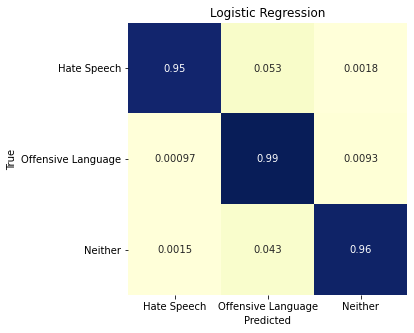

In [60]:
confMat = confusion_matrix(yhat,y_test)
#Since there are 3 classes, want a 3x3 confusion matrix
dims=np.zeros((3,3))
for i in range(0,3):
    dims[i,:] = confMat[i,:]/confMat[i,:].sum()
mapDF = pd.DataFrame(dims, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])

plt.figure(figsize=(5,5))
sb.heatmap(mapDF,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Logistic Regression")


In [61]:
#Random Forest
start=time.time()
modelRF=RandomForestClassifier().fit(X2_train,y_train)
end=time.time()
#get time
runtimeRF=end-start
#get predictions
yhat = modelRF.predict(X2_test)
#get accuracy
accuracyRF=accuracy_score(yhat,y_test)
#get results
results=classification_report(yhat,y_test)
print("RANDOM FOREST")
print(results)
print("Accuracy:" , round(accuracyRF,4))
print("Runtime: ",round(runtimeRF,4))

RANDOM FOREST
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5892
           1       0.94      1.00      0.97      5353
           2       1.00      0.96      0.98      6026

    accuracy                           0.98     17271
   macro avg       0.98      0.98      0.98     17271
weighted avg       0.98      0.98      0.98     17271

Accuracy: 0.9791
Runtime:  311.2766


Text(0.5, 1.0, 'Random Forest')

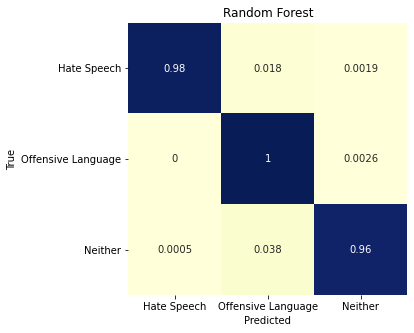

In [62]:
confMat = confusion_matrix(yhat,y_test)
#Since there are 3 classes, want a 3x3 confusion matrix
dims=np.zeros((3,3))
for i in range(0,3):
    dims[i,:] = confMat[i,:]/confMat[i,:].sum()
mapDF = pd.DataFrame(dims, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])

plt.figure(figsize=(5,5))
sb.heatmap(mapDF,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Random Forest")


In [63]:
#Support Vector Machine
start=time.time()
modelSVM=LinearSVC(random_state=123).fit(X2_train,y_train)
end=time.time()
#get time
runtimeSVM=end-start
#get predictions
yhat = modelSVM.predict(X2_test)
#get accuracy
accuracySVM=accuracy_score(yhat,y_test)
#get results
results=classification_report(yhat,y_test)
print("SUPPORT VECTOR MACHINE")
print(results)
print("Accuracy:" , round(accuracySVM,4))
print("Runtime: ",round(runtimeSVM,4))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SUPPORT VECTOR MACHINE
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6090
           1       0.89      0.99      0.94      5114
           2       0.99      0.95      0.97      6067

    accuracy                           0.96     17271
   macro avg       0.96      0.96      0.96     17271
weighted avg       0.96      0.96      0.96     17271

Accuracy: 0.9592
Runtime:  11.8473


Text(0.5, 1.0, 'Support Vector Machine')

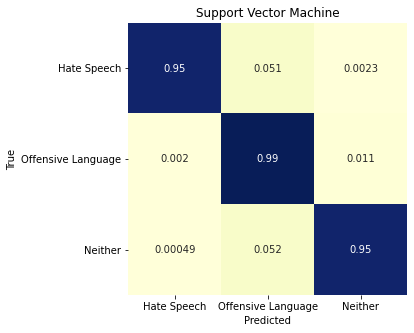

In [64]:
confMat = confusion_matrix(yhat,y_test)
#Since there are 3 classes, want a 3x3 confusion matrix
dims=np.zeros((3,3))
for i in range(0,3):
    dims[i,:] = confMat[i,:]/confMat[i,:].sum()
mapDF = pd.DataFrame(dims, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])

plt.figure(figsize=(5,5))
sb.heatmap(mapDF,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Support Vector Machine")


In [65]:
#Naive Bayes ]
start=time.time()
modelNB=GaussianNB().fit(X2_train,y_train)
end=time.time()
#get time
runtimeNB=end-start
#get predictions
yhat = modelNB.predict(X2_test)
#get accuracy
accuracyNB=accuracy_score(yhat,y_test)
#get results
results=classification_report(yhat,y_test)
print("NAIVE BAYES")
print(results)
print("Accuracy:" , round(accuracyNB,4))
print("Runtime: ",round(runtimeNB,4))

NAIVE BAYES
              precision    recall  f1-score   support

           0       0.53      0.96      0.69      3229
           1       0.67      0.66      0.67      5807
           2       0.99      0.70      0.82      8235

    accuracy                           0.73     17271
   macro avg       0.73      0.77      0.72     17271
weighted avg       0.80      0.73      0.74     17271

Accuracy: 0.7338
Runtime:  27.0266


Text(0.5, 1.0, 'Naive Bayes')

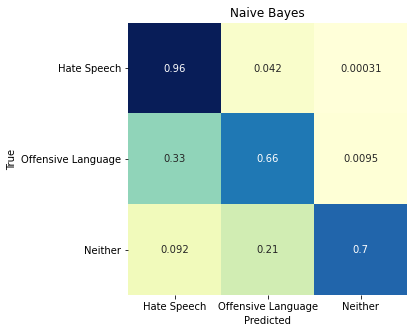

In [66]:
confMat = confusion_matrix(yhat,y_test)
#Since there are 3 classes, want a 3x3 confusion matrix
dims=np.zeros((3,3))
for i in range(0,3):
    dims[i,:] = confMat[i,:]/confMat[i,:].sum()
mapDF = pd.DataFrame(dims, index=['Hate Speech', 'Offensive Language', 'Neither'],
                            columns=['Hate Speech', 'Offensive Language', 'Neither'])

plt.figure(figsize=(5,5))
sb.heatmap(mapDF,annot=True,cmap='YlGnBu', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title("Naive Bayes")


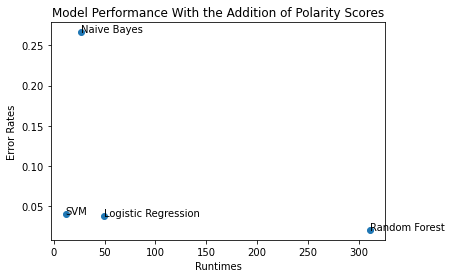

In [67]:
#Plot results (error rate/runtime)
error_rates=[1-accuracyLR,1-accuracyRF,1-accuracySVM,1-accuracyNB]
runtimes=[runtimeLR,runtimeRF,runtimeSVM,runtimeNB]
names=['Logistic Regression','Random Forest', 'SVM', 'Naive Bayes']
plt.scatter(runtimes,error_rates,)
plt.xlabel('Runtimes')
plt.ylabel('Error Rates')
plt.title('Model Performance With the Addition of Polarity Scores')
for i,model in enumerate(names):
    plt.annotate(model, (runtimes[i],error_rates[i]))